In [1]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json

data_file_path = "/content/drive/MyDrive/protein_props/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/druggable_proteins.txt"
approved_druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/approved_druggable_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))


Total number of uniprot human verified proteins: 20434


In [3]:
with open(druggable_proteins_file_path, 'r') as f:
    druggable_proteins = f.read().splitlines()

with open(approved_druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of approved druggable proteins:", len(approved_druggable_proteins))

Number of druggable proteins: 3345
Number of approved druggable proteins: 2652


In [4]:
# Find unique amino acids in protein sequences
unique_amino_acids = set()
for protein in protein_data:
    seq = protein_data[protein]['Sequence']
    for aa in seq:
        unique_amino_acids.add(aa)

print("Number of unique amino acids:", len(unique_amino_acids))
print(unique_amino_acids)

unique_amino_acids = sorted(list(unique_amino_acids))
print(unique_amino_acids)

amino_acid_to_num_mapping = {aa: i+1 for i, aa in enumerate(unique_amino_acids)}
print(amino_acid_to_num_mapping)

Number of unique amino acids: 20
{'E', 'F', 'G', 'L', 'K', 'C', 'T', 'Y', 'P', 'D', 'R', 'W', 'N', 'Q', 'H', 'S', 'A', 'I', 'V', 'M'}
['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


# Grouped dipeptide composition
#### In this approach, amino acids are grouped into five classes using their physicochemical properties i.e., aromatic group (W, Y, and F), positive charge group (H, K, and R), aliphatic group (A, I, M, G, L, and V), uncharged group (C, T, P, S, Q, and N), and negative charged group (D, E, and G) The feature space of the GDPC can be formulated as:

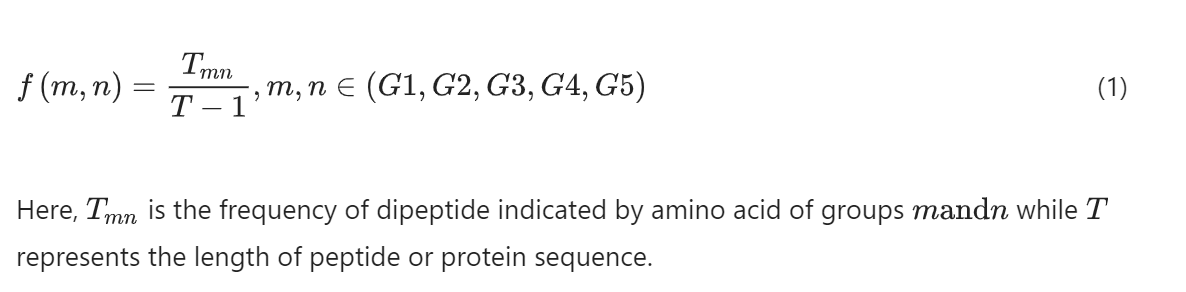

In [19]:
aromatic_group = ['W', 'Y', 'F']
positive_charge_group = ['H', 'K', 'R']
aliphatic_group = ['A', 'I', 'M', 'G', 'L', 'V']
uncharged_group = ['C', 'T', 'P', 'S', 'Q', 'N']
negative_charge_group = ['D', 'E', 'G']
amino_acid_to_grp_mapping = {}
for amino_acid in unique_amino_acids:
  amino_acid_to_grp_mapping[amino_acid] = ""

for group in aromatic_group:
  amino_acid_to_grp_mapping[group] += 'aromatic::'

for group in positive_charge_group:
  amino_acid_to_grp_mapping[group] += 'positive::'

for group in negative_charge_group:
  amino_acid_to_grp_mapping[group] += 'negative::'

for group in uncharged_group:
  amino_acid_to_grp_mapping[group] += 'uncharged::'

for group in aliphatic_group:
  amino_acid_to_grp_mapping[group] += 'aliphatic::'

for amino_acid in amino_acid_to_grp_mapping:
  amino_acid_to_grp_mapping[amino_acid] = amino_acid_to_grp_mapping[amino_acid][:-2]

amino_acid_to_grp_mapping


{'A': 'aliphatic',
 'C': 'uncharged',
 'D': 'negative',
 'E': 'negative',
 'F': 'aromatic',
 'G': 'negative::aliphatic',
 'H': 'positive',
 'I': 'aliphatic',
 'K': 'positive',
 'L': 'aliphatic',
 'M': 'aliphatic',
 'N': 'uncharged',
 'P': 'uncharged',
 'Q': 'uncharged',
 'R': 'positive',
 'S': 'uncharged',
 'T': 'uncharged',
 'V': 'aliphatic',
 'W': 'aromatic',
 'Y': 'aromatic'}

In [20]:
def get_types(aa1, aa2):
  if not("::" in amino_acid_to_grp_mapping[aa1] or "::" in amino_acid_to_grp_mapping[aa2]):
    return [amino_acid_to_grp_mapping[aa1] + "_" + amino_acid_to_grp_mapping[aa2]]
  elif "::" in amino_acid_to_grp_mapping[aa1] and "::" in amino_acid_to_grp_mapping[aa2]:
    return ["negative_negative", "aliphatic_aliphatic", "negative_aliphatic", "aliphatic_negative"]
  elif "::" in amino_acid_to_grp_mapping[aa1]:
    return ["negative_"+amino_acid_to_grp_mapping[aa2], "aliphatic_"+amino_acid_to_grp_mapping[aa2]]
  elif "::" in amino_acid_to_grp_mapping[aa2]:
    return [amino_acid_to_grp_mapping[aa1]+"_negative", amino_acid_to_grp_mapping[aa1]+"_aliphatic"]

In [21]:
def gdpc_encoding(sequence):
  encoding = {}
  for type1 in ["aliphatic", "positive", "negative", "uncharged", "aromatic"]:
    for type2 in ["aliphatic", "positive", "negative", "uncharged", "aromatic"]:
      encoding[type1 + "_" + type2] = 0

  for i in range(len(sequence)-1):
    for type1_type2 in get_types(sequence[i], sequence[i+1]):
      encoding[type1_type2] += 1

  for key in encoding:
    encoding[key] = encoding[key]/(len(sequence)-1)
  return encoding

In [22]:
gdpc_encodings = {}
for protein in protein_data:
  gdpc_encodings[protein] = gdpc_encoding(protein_data[protein]['Sequence'])

In [23]:
gdpc_encodings["P05067"]

{'aliphatic_aliphatic': 0.1378413524057217,
 'aliphatic_positive': 0.04161248374512354,
 'aliphatic_negative': 0.07802340702210664,
 'aliphatic_uncharged': 0.09232769830949285,
 'aliphatic_aromatic': 0.013003901170351105,
 'positive_aliphatic': 0.04681404421326398,
 'positive_positive': 0.022106631989596878,
 'positive_negative': 0.02080624187256177,
 'positive_uncharged': 0.035110533159947985,
 'positive_aromatic': 0.015604681404421327,
 'negative_aliphatic': 0.08062418725617686,
 'negative_positive': 0.031209362808842653,
 'negative_negative': 0.06241872561768531,
 'negative_uncharged': 0.05851755526657997,
 'negative_aromatic': 0.013003901170351105,
 'uncharged_aliphatic': 0.08972691807542263,
 'uncharged_positive': 0.036410923276983094,
 'uncharged_negative': 0.06371911573472042,
 'uncharged_uncharged': 0.07672301690507152,
 'uncharged_aromatic': 0.016905071521456438,
 'aromatic_aliphatic': 0.018205461638491547,
 'aromatic_positive': 0.007802340702210663,
 'aromatic_negative': 0.01

In [24]:
# save this dictionary as a json file in drive
import json
with open('/content/drive/MyDrive/protein_props/gdpc_encodings.json', 'w') as fp:
    json.dump(gdpc_encodings, fp, indent=4)